<img src="./img/HWNI_logo.svg"/>

# Lab A - Two-Way ANOVA - Solutions

In [1]:
# makes our plots show up inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

/Users/charlesfrye/anaconda/envs/neur299_py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## About the Lab

In part A of the lab for this section, we run ANOVA on a simulated dataset using `statsmodels` and connect ANOVA outputs to features of our data visualizations.

## About the Dataset

The data for this lab is simulated.

After learning of [Nemeroff, Heim, et al.](http://www.pnas.org/content/100/24/14293.full)'s finding that psychotherapy is more effective at treating depression in individuals with childhood trauma, you become interested in whether the same might be true for treating anxiety.

You run a clinical experiment in which individuals with and without childhood trauma are treated with a placebo, the standard of care for psychotherapy (CBT, or 
["Cognitive Behavioral Therapy"](https://en.wikipedia.org/wiki/Cognitive_behavioral_therapy)),
or the standard of care for pharmacotherapy
[(an anxiolytic GABA agonist)](https://en.wikipedia.org/wiki/Anxiolytic).
As an aside: in actual clinical studies, treatment with a placebo is considered unethical if there's already a standard of care, and a proper clinical trial compares alternative treatments to standard treatments.

The results of your experiment are summarized in the table `anxiety_dataset.csv`.

## Loading the Data

In [2]:
df = pd.read_csv('./data/anxiety_dataset.csv',index_col=0)

data = df.copy()

In [3]:
data.sample(10)

,treatment,trauma,anxiety_reduction
subjectID,,,
10,placebo,True,2.7
11,drug,False,5.8
12,placebo,False,3.6
18,placebo,False,3.3
14,placebo,False,2.3
7,placebo,True,3.2
15,cbt,False,4.6
14,drug,False,6.0
7,cbt,True,7.0


For the independent variables `treatment` and `trauma`, use the pandas `Series` method `unique` to determine the levels and store these in variables called `treatments` and `traumas`.

In [4]:
treatments = data.treatment.unique()
traumas = data.trauma.unique()

## Visualizing the Data

Visualize the data. Aim for a visualization that makes it possible to see any main effects along with the interaction effect you're interested in. Examples include: histograms, factorial plots (make sure to include error bars), and strip/swarm/violin plots.

#### Q1 Discuss the connections between visual aspects of your graph and 1) the assumptions of ANOVA and 2) the outcomes you expect.

<font color="1874CD"> 

** The answer below is for the histogram. Information about interpreting the factorial plot can be found in the Miller & Haden readings. **

** The assumption of sphericity (equal variances) can be approximately checked by looking at the width of the distributions. The assumption appears to hold in this case. **

** The main effect of trauma can be assessed by looking at the differences in means within each plot. There may be a small main effect of trauma, but it is difficult to tell. **

** The main effect of treatment can be assessed by looking at the differences of means across the plots. The means of both of the non-placebo treatment groups appear to be higher than that of the placebo group, so we expect a main effect of treatment.**

** The interaction effect of trauma and treatment appears as a difference in the location of the trauma group means depending on treatment. We see here that pharmacotherapy appears more effective on individuals with no trauma, while psychotherapy appears to be more effective on individuals with trauma. We expect, therefore, an interaction effect of trauma and treatment. **

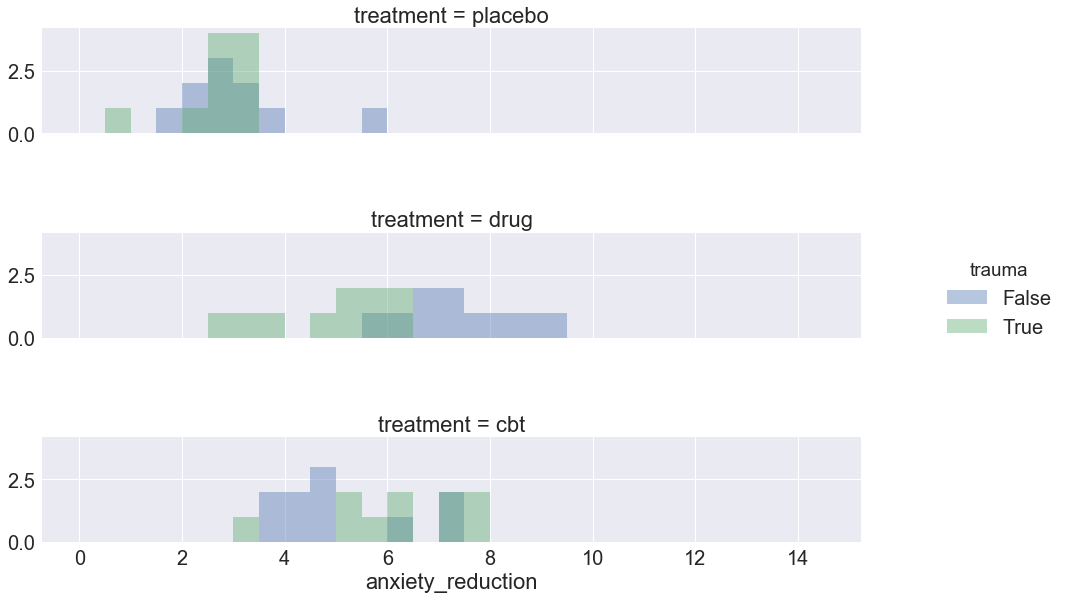

In [5]:
hist_kws = {'histtype':'stepfilled',
               'linewidth':4}

facets = sns.FacetGrid(data=data,
                       row="treatment",
                       hue="trauma",
                        size=2,aspect=4)

facets.map(sns.distplot,"anxiety_reduction",
           kde=False,
           bins=np.arange(0,15,0.5),
           hist_kws=hist_kws).add_legend();

facets.fig.set_size_inches((16,10));

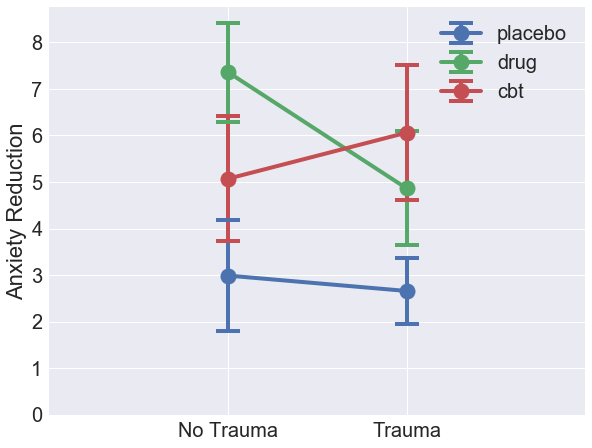

In [6]:
treatmentXtraumaMeans = data.groupby(["treatment","trauma"]).mean()

treatmentXtraumaSDs = data.groupby(["treatment","trauma"]).std()

for treatment in treatments:
    means = treatmentXtraumaMeans.loc[treatment].anxiety_reduction
    errs = np.asarray(treatmentXtraumaSDs.loc[treatment].anxiety_reduction)
    plt.errorbar(x=[0,1],y=means,yerr=errs,label=treatment,
             linewidth=4,alpha=1,capthick=4,capsize=12,
            marker='o',markersize=16)
    
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(["No Trauma","Trauma"])
ax.set_xlim([-1,2])
ax.set_ylabel("Anxiety Reduction")
ylims = ax.get_ylim()
ax.set_ylim([0,ylims[1]])
    
plt.legend();

### Running ANOVA

Because the ANOVA test is, from one perspective, a test of the goodness-of-fit of a linear model, modeling packages provide the tools in Python for performing ANVOAs more complicated than one-way between-subjects.

In this course, we'll be using the `statsmodels` package.

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

We specify models by describing them with strings that look like:

```
    "outcome ~ factor"
```

for one-way ANOVAs,

```
    "outcome ~ factor1*factor2*...factorN"
```

for N-way ANOVAs where we want to compute all main effects and interactions,
and

```
    "outcome ~ factor1:randomFactor1:randomFactor2:...randomFactorN"
```

for ANOVAs with N factors where we're only interested in interactions (e.g., a subject factor).

In [8]:
ols_lm = smf.ols('anxiety_reduction ~ treatment*trauma',data=df)

fit = ols_lm.fit()

table = sm.stats.anova_lm(fit,typ=2)

table

,sum_sq,df,F,PR(>F)
treatment,124.100083,2.0,44.040525,4.530595e-12
trauma,5.612042,1.0,3.983193,5.101057e-02
treatment:trauma,30.958083,2.0,10.986377,9.928169e-05
Residual,76.082250,54.0,NaN,NaN


Hang on to this table of results for comparison with your ANOVA by hand below.

#### Q2 Interpret the pattern of significant and non-significant results that you see. First, phrase your answer as you would write it in the results section of a paper (e.g. using the [APA guidelines](https://depts.washington.edu/psych/files/writing_center/stats.pdf)), then describe the results less formally, as in a research talk.

<font color="1874CD"> ** In a paper, it is expected that you report degrees of freedom and F-statistic values. "We applied a two-way between-subjects ANOVA to the anxiety reduction scores. We report a significant main effect of treatment [(F(2,54)=44.04, p << .001] and a significant interaction of treatment and presence of past trauma [F(2,54) = 10.99, p << .001]". Once could possibly also note the "trend" for an effect of trauma, noting that the observed p-value is 0.051, which is not meaningfully different from 0.05. **

** In a research talk, the findings can be summarized more informally: "Using ANOVA, we found that anxiety reduction scores differed significantly across treatments. We also found that response to treatment varied significantly between subjects with and without a history of trauma." One might go even further and only note that "an ANOVA was performed that revealed a main effect of treatment and an interaction of treatment and trauma history" and then report the results of post-hoc $t$-tests (e.g. a test confirming that CBT was more effective in individuals with a history of trauma).**

Just as we performed an overall $F$-test before doing $t$-tests in a one-way ANOVA, one can also perform an "omnibus" $F$-test before performing the individual $F$-tests of a multi-way ANOVA. In this test, we check to see whether the model as a whole has a significant between-groups mean-square.

We can calculate the model's overall between-groups mean-square by adding up the sums of squares for each component of the model and dividing by the sum of the degrees of freedom of each component of the model. Comparing this to the residual mean square gives us an F for which we can compute a p-value.

The issue of multiple-comparisons in ANOVA and the role of the omnibus test is explored in the second half of the lab.

Implement an omnibus test and run it on the results table above. You'll need the `cdf` method of `scipy.stats.f`. Note that the results table contains all the information you need to run an omnibus test.

In [9]:
#scipy.stats.f?

In [10]:
def compute_p(f_value, dof_b, dof_w):
    f_distribution = scipy.stats.f
    p = 1 - f_distribution.cdf(f_value, dof_b, dof_w)
    return p

def omnibus_test(result):
    
    model = result[:-1]
    residual = result.iloc[-1]
    
    dof = np.sum(model['df'])
    
    meansquare_explained = np.sum(model['sum_sq'])/dof
    
    meansquare_unexplained = residual['sum_sq']/residual['df']
    
    F = meansquare_explained/meansquare_unexplained
    
    p = compute_p(F,dof,residual['df'])
    return (F,p)

In [11]:
F,p = omnibus_test(table)
print((F,p))

(22.807399229123739, 3.1621372187373709e-12)
